In [53]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix
import numpy as np
import os
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
import os
import matplotlib.pyplot as plt


### Bayesian document categorization: Bernoulli model

In [54]:
def get_bug_of_words(path):
    with open(path, "r", encoding="utf-8") as file:
        text = file.read()
    # Удаляем заголовок и метаданные, оставляя только тело сообщения
    body = text.split("\n\n", 1)[-1]
    # Удаляем строки с цитатами (начинаются с ">") и лишние пробелы
    body_cleaned = re.sub(r"^>.*", "", body, flags=re.MULTILINE).strip()
    
    body_cleaned = re.sub(r"[^\w\s]", "", body_cleaned)  # Убираем спецсимволы
    body_cleaned = re.sub(r"\d+", "", body_cleaned)  # Убираем числа
    
    body_cleaned = body_cleaned.lower()
    words_set = set(body_cleaned.split())
    
    # Выводим результат
    return words_set

In [55]:
categories = {"autos": 0, "med" : 0, "motorcycles": 0, "religion_christian": 0, "politics_mideast": 0, "space": 0}

In [56]:
def get_folder_structure(folder_path):
    folder_dict = {}
    for root, dirs, files in os.walk(folder_path):
        rel_path = os.path.relpath(root, folder_path)
        current_folder = folder_dict if rel_path == "." else get_nested_dict(folder_dict, rel_path.split(os.sep))
        current_folder.update({file: None for file in files})
        for d in dirs:
            current_folder[d] = {}
    return folder_dict

def get_nested_dict(base_dict, keys):
    for key in keys:
        base_dict = base_dict.setdefault(key, {})
    return base_dict
folder_structure = get_folder_structure("./data_ml_v2-11")

In [57]:
folder_structure.pop("stopwords")

In [58]:
stopwords = get_bug_of_words("./data_ml_v2-11/stopwords")

In [59]:
def set_bug_of_words(folder_structure):
    common_bug = set()
    doc_index_list= []
    topic_docs_indexes =  dict()
    for topic, name_sets in folder_structure.items():
        topic_docs_indexes.update({topic:[]})
        cnt = 0 
        for name_doc, _ in name_sets.items():
            doc_index = f"{topic}/{name_doc}"
            doc_index_list.append(doc_index)
            topic_docs_indexes[topic].append(doc_index)
            res = os.path.join(os.path.curdir,"data_ml_v2-11", topic,f"{name_doc}" )
            value  = get_bug_of_words(res)
            folder_structure[topic][name_doc] = value
            common_bug = common_bug.union(value)
            cnt+=1
        categories[topic] = cnt
    return common_bug, doc_index_list, topic_docs_indexes 
    

In [60]:
com_bug, doc_indexes, topic_docs_indexes = set_bug_of_words(folder_structure) # формируем общий мешок слов

In [61]:
def task1(folder_structure, com_bug,stopwords):
    full_unique_words = np.array([])
    full_unique_withstopwords = np.array([])
    for topic, name_sets in folder_structure.items():
        unique_words= []
        unique_words_wout_stopwords= []
        for name_doc, _ in name_sets.items():
            unique_words.append(len(folder_structure[topic][name_doc]))
            unique_words_wout_stopwords.append( len(folder_structure[topic][name_doc] - stopwords))
        unique_words = np.array(unique_words)
        unique_words_wout_stopwords = np.array(unique_words_wout_stopwords)
        print(f"{topic} mean unqiue:{np.mean(unique_words):.2f}, std:{np.std(unique_words):.2f}")
        print(f"{topic} mean unqiue\(stopwords):{np.mean(unique_words_wout_stopwords):.2f}, std:{np.std(unique_words_wout_stopwords):.2f}")
        full_unique_words = np.hstack((full_unique_words, unique_words))
        full_unique_withstopwords = np.hstack((full_unique_words, unique_words_wout_stopwords))
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 строка, 2 столбца

    # Построение первой гистограммы
    axes[0].hist(full_unique_words, bins=30, edgecolor='black', alpha=0.7)
    axes[0].set_title("Распределение кол-ва уникальных слов")
    axes[0].set_xlabel("Значения")
    axes[0].set_ylabel("Частота")
    
    # Построение второй гистограммы
    axes[1].hist(full_unique_withstopwords, bins=30, edgecolor='black', alpha=0.7, color='orange')
    axes[1].set_title("Распределение кол-ва уникальных слов без стопслов")
    axes[1].set_xlabel("Значения")
    axes[1].set_ylabel("Частота")
    
    # Показ графиков
    plt.tight_layout()  # Автоматическая оптимизация расположения графиков
    plt.show()
    

### 1. Для каждой категории рассчитать среднее значение и с.к.о. (по документам) числа содержащихся в них различных (повторы не учитывать): а) слов; б) стоп-слов. Построить гистограммы распределения документов по числу содержащихся в них: а) различных слов; б) различных стоп-слов.

autos mean unqiue:84.30, std:60.52
autos mean unqiue\(stopwords):46.38, std:38.96
med mean unqiue:156.28, std:204.61
med mean unqiue\(stopwords):100.89, std:168.32
motorcycles mean unqiue:87.94, std:54.42
motorcycles mean unqiue\(stopwords):48.85, std:35.11
politics_mideast mean unqiue:139.15, std:139.68
politics_mideast mean unqiue\(stopwords):88.62, std:110.23
religion_christian mean unqiue:167.51, std:144.36
religion_christian mean unqiue\(stopwords):98.75, std:102.63
space mean unqiue:130.84, std:185.23
space mean unqiue\(stopwords):85.81, std:153.33


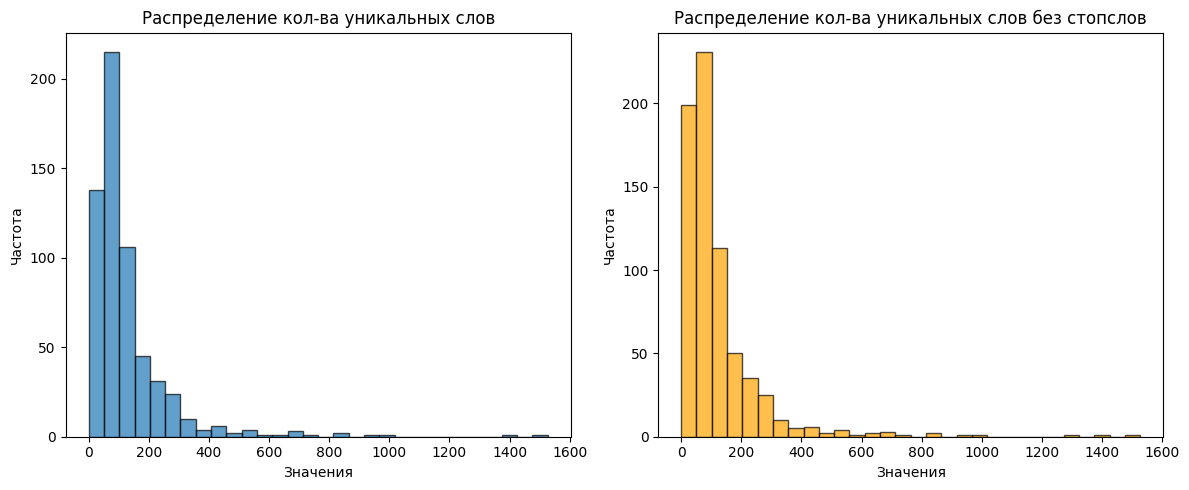

In [62]:
task1(folder_structure, com_bug, stopwords)

In [69]:
def bugs_without_stopwords(folder_structure, com_bug, stopwords):
    for topic, name_sets in folder_structure.items():
        for name_doc, _ in name_sets.items():
            folder_structure[topic][name_doc] = folder_structure[topic][name_doc] - stopwords
    return  com_bug - stopwords

### 2. Сформировать словарь (из всех слов, встречающихся во всех документах), исключить из словаря стоп-слова.

In [64]:
com_bug = bugs_without_stopwords(folder_structure, com_bug, stopwords)

In [93]:
len(com_bug)

16893

### 3. Сформировать и визуализировать бинарную матрицу вхождения слов в документы (по строкам – документы, по столбцам – слова из словаря, 1 – слово встречается в документе, 0 – не встречается).

In [65]:
data = pd.DataFrame(0,columns=list(com_bug), index=doc_indexes)

In [66]:
data["CLASS_"] = None

In [67]:
def fill_table(folder_structure,data):
    for topic, name_sets in folder_structure.items():
        for name_doc, _ in name_sets.items():
            doc_index = f"{topic}/{name_doc}"
            bug_words_of_doc = folder_structure[topic][name_doc]
            data.loc[doc_index, list(bug_words_of_doc)] = 1
            data.loc[doc_index, "CLASS_"] = topic

In [68]:
fill_table(folder_structure,data)

### покажем первые 10 документов и 10 слов( матрица огромная)

In [72]:
data.iloc[:10,:10]

,factory,rcc,procedures,negotiable,preceding,solidarity,wednesdays,faulty,syntactic,unfair
autos/101564,0,0,0,0,0,0,0,0,0,0
autos/101577,0,0,0,0,0,0,0,0,0,0
autos/101592,0,0,0,0,0,0,0,0,0,0
autos/101597,0,0,0,0,0,0,0,0,0,0
autos/101603,0,0,0,0,0,0,0,0,0,0
autos/101609,0,0,0,0,0,0,0,0,0,0
autos/101614,0,0,0,0,0,0,0,0,0,0
autos/101624,0,0,0,0,0,0,0,0,0,0
autos/101628,0,0,0,0,0,0,0,0,0,0
autos/101629,0,0,0,0,0,0,0,0,0,0


### 4. Построить модель  и  матрицу ошибок (confusion matrix) классификатора.

In [73]:
prior_probs =  pd.DataFrame(0.0,index = list(com_bug), columns=categories.keys())

In [74]:
N = sum(categories.values())

In [75]:
def  compute_prior_probs(data,prior_probs,topic_docs_indexes):
    for idx, row in prior_probs.iterrows():
        for col in row.index:
            n_j_k =  float(data.loc[topic_docs_indexes[col],idx].sum())
            prior_probs.loc[idx,col] = n_j_k / categories[col] 

In [76]:
compute_prior_probs(data, prior_probs, topic_docs_indexes)

In [77]:
y = data["CLASS_"]
X = data[list(com_bug)]
prior_probs.head(5)

In [80]:
prior_probs.head(5)

,autos,med,motorcycles,religion_christian,politics_mideast,space
factory,0.01,0.00,0.01,0.00,0.00,0.000000
rcc,0.00,0.00,0.00,0.01,0.00,0.000000
procedures,0.00,0.01,0.00,0.00,0.00,0.010309
negotiable,0.01,0.00,0.00,0.00,0.00,0.000000
preceding,0.00,0.01,0.00,0.01,0.01,0.010309


In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train.shape

(417, 16893)

In [88]:
def log_discriminant(row):
    categories_score = categories.copy()
    eps = 10e-9 #добавка, чтобы логарифм считался
    for topic, n_k in categories.items():
        res = np.dot(row.values, np.log(prior_probs.loc[:,topic].values + eps)) +   np.dot(1- row.values, np.log(1 - prior_probs.loc[:,topic].values)) + np.log(n_k/N)
        categories_score[topic] = res
    most_prob_class = sorted(categories_score, key=categories_score.get, reverse=True)[0]
    return most_prob_class

In [89]:
def predict(X_test):
    y_pred  =  X_test.apply(log_discriminant, axis= 1)
    return y_pred

In [90]:
y_pred = predict(X_test)

In [91]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[30  0  0  0  0  0]
 [ 0 30  0  0  0  0]
 [ 0  0 30  0  0  0]
 [ 0  0  0 30  0  0]
 [ 0  0  0  0 30  0]
 [ 1  0  1  0  0 28]]


## 5. Рассчитать micro-averaged и macro-averaged показатели, основанные на таблице сопряженности: accuracy, recall, precision, F1-score, Cohen’s kappa

In [104]:
def compute_metric(y_test, y_pred,  type = "macro"):
    print(f"{type}-averaged:")
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy:, {accuracy:.5f}")
    
    precision = precision_score(y_test, y_pred, average=type)  # для всех классов
    print(f"Precision:, {precision:.5f}")
    
    recall = recall_score(y_test, y_pred, average=type)  # для всех классов
    print(f"Recall: {recall:.5f}")
    
    f1 = f1_score(y_test, y_pred, average=type)  # для всех классов
    print(f"F1-Score:, {f1:.5f}")
    
    kappa = cohen_kappa_score(y_test, y_pred)
    print("Cohen's kappa:", kappa)

In [106]:
compute_metric(y_test, y_pred, "micro")

micro-averaged:
Accuracy:, 0.98889
Precision:, 0.98889
Recall: 0.98889
F1-Score:, 0.98889
Cohen's kappa: 0.9866666666666667


In [108]:
compute_metric(y_test, y_pred, "macro")

macro-averaged:
Accuracy:, 0.98889
Precision:, 0.98925
Recall: 0.98889
F1-Score:, 0.98879
Cohen's kappa: 0.9866666666666667
